<a href="https://colab.research.google.com/github/hr1588/NLP/blob/main/chapter_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=5)

Cloning into 'nlp-with-transformers'...
remote: Enumerating objects: 588, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 588 (delta 5), reused 3 (delta 1), pack-reused 569
Receiving objects: 100% (588/588), 57.41 MiB | 20.10 MiB/s, done.
Resolving deltas: 100% (293/293), done.
/content/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.26.1
Using datasets v2.10.1
Using accelerate v0.17.1
Using sentencepiece v0.1.97


# 그리디 서치 디코딩

In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"

model_name = "gpt2"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

In [4]:
import pandas as pd

input_txt = 'Transformers are the'
input_ids = tokenizer(input_txt, return_tensors = 'pt')['input_ids'].to(device)
iterations = []
n_steps = 8
choices_per_step = 5

In [5]:
input_ids

tensor([[41762,   364,   389,   262]], device='cuda:0')

In [6]:
tokenizer.decode(input_ids[0])

'Transformers are the'

In [7]:
with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration['input'] = tokenizer.decode(input_ids[0])
        output = model(input_ids = input_ids)
        # 첫 번째 배치의 마지막 토큰의 로짓을 선택에 softmax 적용
        next_token_logits = output.logits[0,-1,:]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
        # 가장 높은 확률의 토큰을 저장
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = (
                f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
            )
            iteration[f"Choice {choice_idx+1}"] = token_choice
        # 예측한 다음 토큰을 입력에 추가
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
        iterations.append(iteration)
        
pd.DataFrame(iterations)


,input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Transformers are the,most (9.76%),same (2.94%),only (2.87%),best (2.38%),first (1.77%)
1,Transformers are the most,common (22.90%),powerful (6.88%),important (6.32%),popular (3.95%),commonly (2.14%)
2,Transformers are the most common,type (15.06%),types (3.31%),form (1.91%),way (1.89%),and (1.49%)
3,Transformers are the most common type,of (83.13%),in (3.16%),. (1.92%),", (1.63%)",for (0.88%)
4,Transformers are the most common type of,particle (1.55%),object (1.02%),light (0.71%),energy (0.67%),objects (0.66%)
5,Transformers are the most common type of particle,. (14.26%),in (11.57%),that (10.19%),", (9.57%)",accelerator (5.81%)
6,Transformers are the most common type of parti...,They (17.48%),\n (15.19%),The (7.06%),These (3.09%),In (3.07%)
7,Transformers are the most common type of parti...,are (38.78%),have (8.14%),can (7.98%),'re (5.04%),consist (1.57%)


In [11]:
next_token_logits

tensor([-128.7654, -127.9221, -130.6394,  ..., -138.0312, -130.7539,
        -128.6092], device='cuda:0')

In [10]:
next_token_logits.shape # gpt2의 "vocab_size": 50257

torch.Size([50257])

In [9]:
next_token_probs

tensor([6.8795e-07, 1.5988e-06, 1.0560e-07,  ..., 6.5080e-11, 9.4177e-08,
        8.0427e-07], device='cuda:0')

In [12]:
next_token_probs.shape

torch.Size([50257])

In [21]:
input_ids = tokenizer(input_txt, return_tensors = 'pt')['input_ids'].to(device)
output = model.generate(input_ids, max_new_tokens = n_steps, do_sample = False) # 샘플링 전략 사용

In [22]:
output

tensor([[41762,   364,   389,   262,   749,  2219,  2099,   286, 18758,    13,
          1119,   389]], device='cuda:0')

In [23]:
tokenizer.decode(output[0])

'Transformers are the most common type of particle. They are'

In [24]:
max_length = 128
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length, 
                               do_sample=False)
print(tokenizer.decode(output_greedy[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


"The unicorns were very intelligent, and they were very intelligent," said Dr.
David S. Siegel, a professor of anthropology at the University of California,
Berkeley. "They were very intelligent, and they were very intelligent, and they
were very intelligent, and they were very intelligent, and they were very
intelligent, and they were very intelligent, and they were very intelligent, and
they were very


# 빔 서치 디코딩

In [25]:
0.5 ** 1024

5.562684646268003e-309

In [26]:
import numpy as np

sum([np.log(0.5)] * 1024)

-709.7827128933695

In [27]:
import torch.nn.functional as F

def log_probs_from_logits(logits, labels):
    logp = F.log_softmax(logits, dim=-1)
    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
    return logp_label

In [28]:
def sequence_logprob(model, labels, input_len=0):
    with torch.no_grad():
        output = model(labels)
        log_probs = log_probs_from_logits(
            output.logits[:, :-1, :], labels[:, 1:])
        seq_log_prob = torch.sum(log_probs[:, input_len:])
    return seq_log_prob.cpu().numpy()

In [29]:
logp = sequence_logprob(model, output_greedy, input_len=len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
print(f"\n로그 확률: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


"The unicorns were very intelligent, and they were very intelligent," said Dr.
David S. Siegel, a professor of anthropology at the University of California,
Berkeley. "They were very intelligent, and they were very intelligent, and they
were very intelligent, and they were very intelligent, and they were very
intelligent, and they were very intelligent, and they were very intelligent, and
they were very

로그 확률: -83.33


In [32]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=4, #1보다 큰 값을 지정, 1이면 greedy와 동일
                             do_sample=False)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\n로그 확률: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


According to the researchers, the unicorns were able to communicate with each
other in a way that was similar to that of humans. The unicorns were able to
communicate with each other in a way that was similar to that of humans. The
unicorns were able to communicate with each other in a way that was similar to
that of humans.

The researchers found that the unicorns were able to communicate

로그 확률: -53.20


In [34]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=4, 
                             do_sample=False, no_repeat_ngram_size=2) # 2-gram의 어구가 반복되지 않도록 설정함

logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\n로그 확률: {logp:.2f}") # n-gram 패널티를 주면 오히려 확률이 감소

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The researchers, from the University of California, San Diego, and the National
Science Foundation (NSF) in Boulder, Colorado, were able to translate the words
of the unicorn into English, which they then translated into Spanish.

"This is the first time that we have translated a word into a language other
than English," said study co-author Dr. David J. Karpeles,

로그 확률: -103.69


In [36]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=4, 
    no_repeat_ngram_size=2, num_return_sequences=4, # 개수만큼의 문장을 리턴, 이때 num_beams와 파라미터가 동일해야 함.
    early_stopping=True)

logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\n로그 확률: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The researchers, from the University of California, San Diego, and the National
Science Foundation (NSF) in Boulder, Colorado, were able to translate the words
of the unicorn into English, which they then translated into Spanish.

"This is the first time that we have translated a word into a language other
than English," said study co-author Dr. David J. Karpeles,

로그 확률: -417.31


# 샘플링

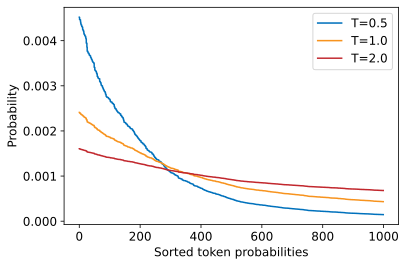

In [38]:
import matplotlib.pyplot as plt
import numpy as np

def softmax(logits, T=1):
    e_x = np.exp(logits / T)
    return e_x / e_x.sum()

logits = np.exp(np.random.random(1000))
sorted_logits = np.sort(logits)[::-1]
x = np.arange(1000)

for T in [0.5, 1.0, 2.0]:
    plt.step(x, softmax(sorted_logits, T), label=f"T={T}")
plt.legend(loc="best")
plt.xlabel("Sorted token probabilities")
plt.ylabel("Probability")
plt.show() # 세 개의 온도에서 랜덤하게 생성한 토큰 확률의 분포

In [40]:
sorted_logits[:10]

array([2.71808801, 2.71722365, 2.71212045, 2.71188437, 2.71158741,
       2.7060742 , 2.70141974, 2.69880552, 2.69834766, 2.69508118])

In [42]:
x[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [43]:
torch.manual_seed(42)

In [44]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             temperature=2.0, top_k=0)
print(tokenizer.decode(output_temp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


Banglington station 21 protagonist Breeboarding Chief Steve had storage goats
invaded Speech spreading immune deficient laugh human massage irrational İvezin
A jer Turner DorStatic errkg meremavern stall class inequariansiamond disse *
Runew Endurance whilst spear secured conference be ankles coaching bees Zika MIA
press Vatican credentials Wrestling chargesThings does Gu Buffer Ty physician
Hidden Kimville66 Scotland Oz at affopy temporou MD sociology Canada iter


# top-k 및 뉴클리어스 샘플링

In [45]:
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)

In [46]:
import torch.nn.functional as F

with torch.no_grad():
    output = model(input_ids=input_ids)
    next_token_logits = output.logits[:, -1, :]
    probs = F.softmax(next_token_logits, dim=-1).detach().cpu().numpy()

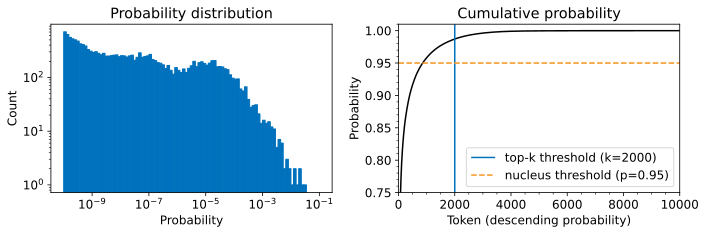

In [47]:
#다음 토큰 예측의 확률 분포(왼쪽)과 내림차순으로 정렬된 토큰 확률의 누적 분포
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

axes[0].hist(probs[0], bins=np.logspace(-10, -1, 100), color="C0", edgecolor="C0")
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_title("Probability distribution")
axes[0].set_xlabel("Probability")
axes[0].set_ylabel("Count")
#axes[0].grid(which="major")

axes[1].plot(np.cumsum(np.sort(probs[0])[::-1]), color="black")
axes[1].set_xlim([0, 10000])
axes[1].set_ylim([0.75, 1.01])
axes[1].set_title("Cumulative probability")
axes[1].set_ylabel("Probability")
axes[1].set_xlabel("Token (descending probability)")
#axes[1].grid(which="major")
axes[1].minorticks_on()
#axes[1].grid(which='minor', linewidth='0.5')
top_k_label = 'top-k threshold (k=2000)'
top_p_label = 'nucleus threshold (p=0.95)'
axes[1].vlines(x=2000, ymin=0, ymax=2, color='C0', label=top_k_label)
axes[1].hlines(y=0.95, xmin=0, xmax=10000, color='C1', label=top_p_label, linestyle='--')
axes[1].legend(loc='lower right')
plt.tight_layout()

In [48]:
output_topk = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             top_k=50)
print(tokenizer.decode(output_topk[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


Scientists from the University's Department of Ethnological Research said that
the unicorns lived in a region covered with a dense, forest-covered area. They
learned that the unicorns use both hands to retrieve and use food items.
Although they did not interact with the humans, the animal was able to sense the
person's voice.


"It is not uncommon to see birds on such a vast range


In [49]:
output_topp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             top_p=0.90)
print(tokenizer.decode(output_topp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


Advertisement

A new study from Oxford University is shedding light on the story of a single
unicorn that traveled to Australia and brought back the perfect English word to
the Australian language. In fact, the unicorn was probably already extinct in
the wild.

"The unicorn was not introduced by a single person in Australia," says Peter
Zoller, a Ph.D. candidate in Zoology and Zoology at
